### You can run this notebook at Colab by clicking here:

<a target="_blank" href="https://colab.research.google.com/github/NMRLipids/databank-template/blob/main/scripts/template.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Initialize NMRlipids databank

In [12]:

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

databankPath = "/appl/local/csc/datasets/NMRLipids/Databank/"  # this is the local path for the cloned Databank
os.environ["NMLDB_ROOT_PATH"] = "/appl/local/csc/datasets/NMRLipids/Databank/"


In [13]:
import random

# These two lines include core Databank routines and Databank API
from DatabankLib.core import *
from DatabankLib.databankLibrary import *

# This initializes the databank and stores the information of all simulations into a list.
# Each list item contains the information from README.yaml file of the given simulation.
systems = initialize_databank()

Databank initialized from the folder: /pfs/lustrep4/scratch/project_462000007/yetukuri/NMRLipids/Databank/Data/Simulations


# Select random simulation for example and show its content

In [14]:
 ### To exemplify the analysis of any simulation, we select randomly one simulation ID
randomID = None
while randomID is None:
    _rid = random.randint(1, len(systems))
    try:
        system = systems.loc(_rid)
        randomID = _rid
    except KeyError:
        pass
randomID = random.randint(1, len(systems))
#randomID=546
print('ID of the selected simulation: ', randomID)

# get system by ID
system = systems.loc(randomID)
print_README(system)

ID of the selected simulation:  303
AUTHORS_CONTACT:
  Javanainen, Matti
FF_DATE:
  None
SYSTEM:
  232DAPC_56CHOL_11520SOL_310K
TYPEOFSYSTEM:
  lipid bilayer
TEMPERATURE:
  310.0
PUBLICATION:
  None
NUMBER_OF_ATOMS:
  70720
EXPERIMENT:
  {'ORDERPARAMETER': {'CHOL': {}, 'DAPC': {}}, 'FORMFACTOR': {}}
FF_SOURCE:
  CHARMM-GUI v1.7
COMPOSITION:
  {'CHOL': {'NAME': 'CHL1', 'COUNT': [28, 28], 'MAPPING': 'mappingCHOLESTEROLcharmm.yaml'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 11520, 'MAPPING': 'mappingTIP3PCHARMMgui.yaml'}, 'DAPC': {'NAME': 'DAPC', 'COUNT': [116, 116], 'MAPPING': 'mappingDAPCcharmm.yaml'}}
TIMELEFTOUT:
  0
CPT:
  [['DAPC_AA_CHOL20_310.cpt']]
TRJLENGTH:
  1000100.0
TRAJECTORY_SIZE:
  2638277776
SOFTWARE_VERSION:
  None
FF:
  CHARMM36
TOP:
  [['DAPC_AA_CHOL20.top']]
PREEQTIME:
  0
DOI:
  10.5281/zenodo.2653721
DATEOFRUNNING:
  07/10/2021
TPR:
  [['DAPC_AA_CHOL20_310.tpr']]
TRJ:
  [['DAPC_AA_CHOL20_310.xtc']]
LOG:
  [['DAPC_AA_CHOL20_310.log']]
SOFTWARE:
  gromacs
DIR_WRK:
  /usr/home

# Show analyzed properties stored in the NMRlipids databank for the selected system:

Membrane area per lipid: 64.94232329086424 

Membrane thickness: 3.95421883392334 

Relative equilibration time for each lipid in the simulation: 
{'DAPC': 0.08119657450657004}


Plot form factor and C-H bond order parameters from the simulation together with experimental data if available 

CHOL
DOI:  10.5281/zenodo.2653721
Force field quality not found


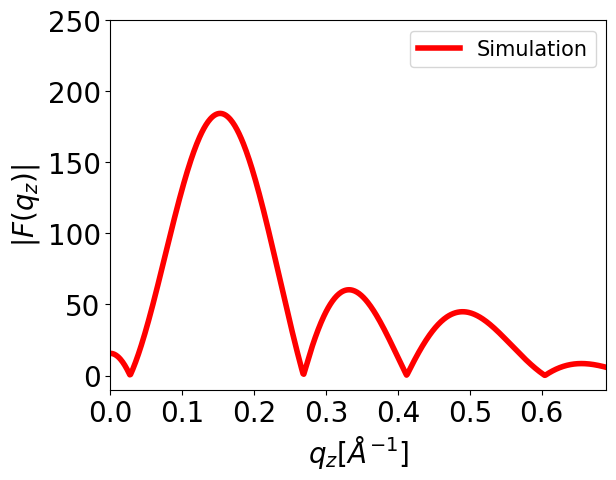

Form factor plotting failed


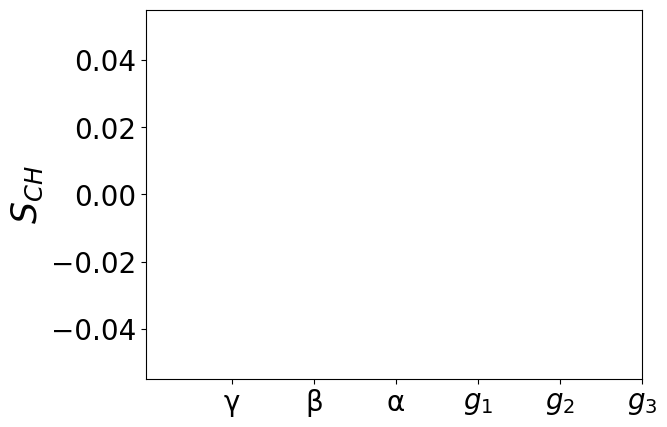

Plotting failed for  CHOL
min() arg is an empty sequence
DAPC
DOI:  10.5281/zenodo.2653721
Force field quality not found


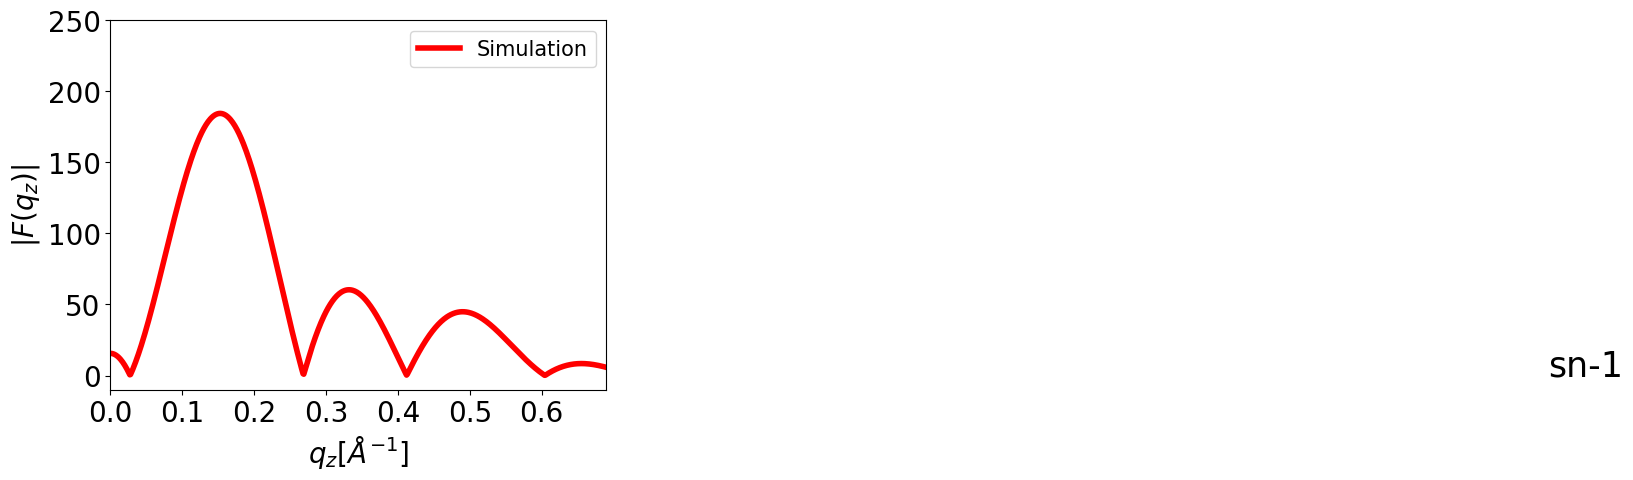

Form factor plotting failed


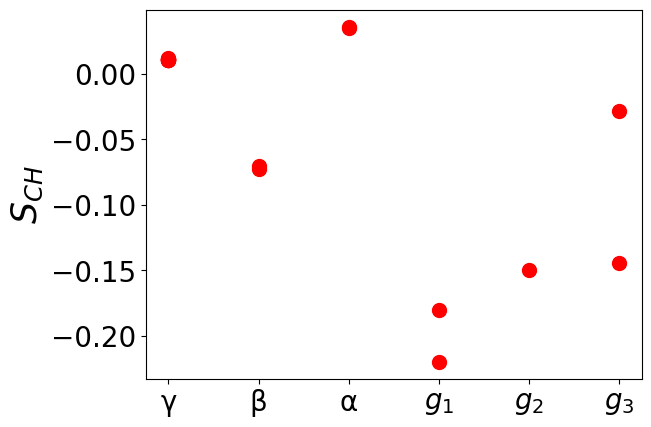

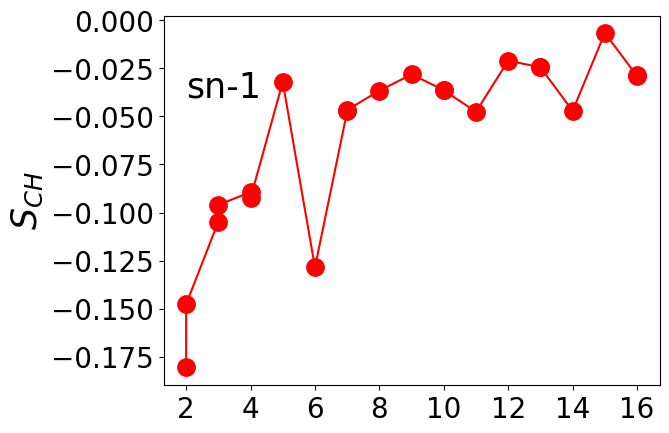

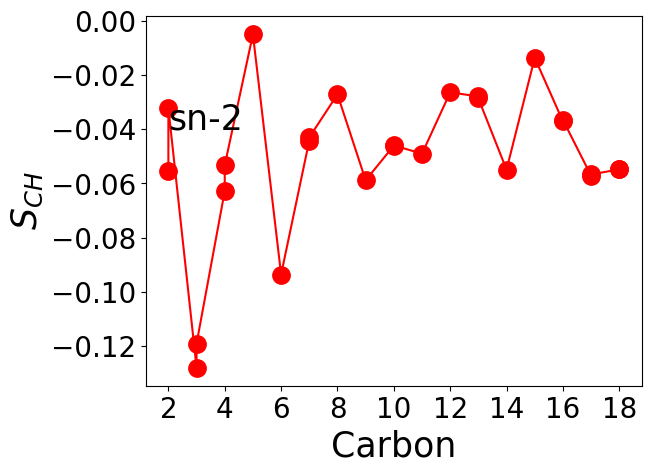

In [15]:
from DatabankLib.plottings import plotSimulation

## Membrane area per lipid, thickness, relative equilibration time, C-H bond order parameters
## and X-ray scattering form factors shown for the selected random simulation.
## We are doing all these things for a randomly picked system (loaded above).

APL = CalcAreaPerMolecule(system)
print('Membrane area per lipid:' , APL, '\n')

thickness = GetThickness(system)
print('Membrane thickness:' , thickness, '\n')

print('Relative equilibration time for each lipid in the simulation: ')
print(GetEquilibrationTimes(system))
print('\n')

print('Plot form factor and C-H bond order parameters from the simulation together with experimental data if available \n')
for lipid in system['COMPOSITION']:
    if lipid not in lipids_set:
        continue
    print(lipid)
    try:
        plotSimulation(system, lipid)
    except Exception as e:
        print('Plotting failed for ', lipid)
        print(e)


# Selects a random simulation with the trajectory size below 100Mb and calculates P-N vector angle with respect to membrane normal for all lipids for which P and N atoms are available in headgroup

In [16]:
systems.loc(756)

System(756): 30e/6ee/30e6eedb46c2d313b709697ae73f0671c5079dc6/7aac3f64c8467f18f5265bc5aa63ed6895c348cf/

In [17]:
## Print simulation specific

Patom_UNI = 'M_G3P2_M'   # universal name of phophate headgroup atom
Natom_UNI = 'M_G3N6_M'   # universal name of nitrogen headgroup atom


## Finding a random simulation with smaller than 100Mb trajectory for testing
for i in range(len(systems)):
    randomID = random.randint(1, len(systems))
    try:
        system = systems.loc(randomID)
    except KeyError:
        pass
    # This filters out larger than 100Mb trajectories for testing
    if system['TRAJECTORY_SIZE'] < 100000000:
        break

print('ID number of the selected simulation: ', randomID)

# Creates MDAnalysis universe from the simulation
# This will also download simulation files if not yet available locally
MDAuni = system2MDanalysisUniverse(system)

# Loops over molecules and calculates P-N vector angle if atoms are found
for molecule in system['COMPOSITION']:
    if molecule not in lipids_set:
        continue
    print('\n Analysing ' + molecule)
    Patom_SIM = simulation2universal_atomnames(system,molecule,Patom_UNI)
    #print(Patom_SIM)
    Natom_SIM = simulation2universal_atomnames(system,molecule,Natom_UNI)
    #print(Natom_SIM)
    if Patom_SIM == None or Natom_SIM == None:
        continue

    #print(molecule, Patom_SIM, Natom_SIM)
    resname = system['COMPOSITION'][molecule]['NAME']
    PNangles = read_trj_PN_angles(resname, Patom_SIM, Natom_SIM, MDAuni)

    print('PN vector angle for ' + molecule + ':' + str(PNangles[2]) + ' +/- ' + str(PNangles[3]) + '\n')

ID number of the selected simulation:  553

 Analysing DLIPC
PN vector angle for DLIPC:71.4496369729433 +/- 0.11216283682603001

